In [1]:
from tqdm import tqdm
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision import datasets, transforms

from IPython import display
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from torch.utils.tensorboard import SummaryWriter
import time, datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Alessandro\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to a tensor.
    transforms.Resize((256, 256))  # Resize the image to 256x256 for each channel.
])

# Load the whole dataset
whole_dataset = datasets.EuroSAT(
    root="data",
    download=True,
    transform=transform
)

# Determine the lengths of the splits
train_len = int(len(whole_dataset) * 0.8)  # 80% for training
test_len = len(whole_dataset) - train_len  # 20% for testing

# Create the splits
training_data, test_data = torch.utils.data.random_split(whole_dataset, [train_len, test_len])

# Create the data loaders
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


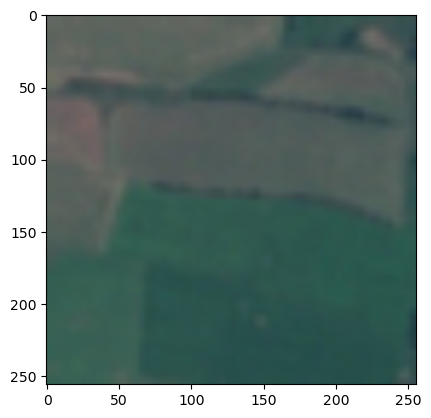

Label: 5


In [3]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1,2,0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [4]:
import math
import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(train_dataloader, optimizer, aux_optimizer, net, lmbda):
    net.train()  # Set the model to training mode
    for i, (batch, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        aux_optimizer.zero_grad()
        batch = batch.to(device)

        outputs = net(batch)
        x_hat = outputs["x_hat"]
        y_likelihoods = outputs["likelihoods"]["y"]


        # Calculate the bitrate of the quantized latent
        N, C, H, W = batch.size()
        num_pixels = N * H * W *C

        bpp_loss = torch.log(y_likelihoods).sum() / (-math.log(2) * num_pixels)

        # Calculate the mean square error
        mse_loss = F.mse_loss(batch, x_hat)

        # Calculate PSNR
        max_i = 1.0  # Assuming the input is normalized to [0, 1]
        psnr = 10 * torch.log10(max_i ** 2 / mse_loss)

        # Calculate the final loss term
        loss = mse_loss + lmbda * bpp_loss
        loss.backward()
        optimizer.step()

        # Additional loss from the entropy bottleneck
        aux_loss = net.entropy_bottleneck.loss()
        aux_loss.backward()
        aux_optimizer.step()

        print(f"Batch {i}: Loss: {loss.item()}, PSNR: {psnr.item()}, BPP: {bpp_loss.item()}")
    return loss.item(), psnr.item()

def test_model(test_dataloader, net, device):
    net.eval()
    avg_psnr = 0.0
    avg_ssim = 0.0
    total_batches = len(test_dataloader)
    num_images_to_plot = 5
    fig, axs = plt.subplots(num_images_to_plot, 2, figsize=(10, 2 * num_images_to_plot))

    with torch.no_grad():
        for i, (batch, _) in enumerate(test_dataloader):
            batch = batch.to(device)
            outputs = net(batch)
            x_hat = outputs["x_hat"]
            y_likelihoods = outputs["likelihoods"]["y"]

            mse_loss = F.mse_loss(batch, x_hat)

            max_i = 1.0  # Normalize input to [0, 1]
            batch_psnr = 10 * torch.log10(max_i ** 2 / mse_loss)
            avg_psnr += batch_psnr.item()

            batch_ssim = ssim(batch.cpu().numpy(), x_hat.cpu().numpy(), channel_axis = 1, data_range=1)
            avg_ssim += batch_ssim

            # Plotting the original and reconstructed images
            if i < num_images_to_plot:
                axs[i, 0].imshow(batch[0].cpu().numpy().transpose(1, 2, 0))
                axs[i, 1].imshow(x_hat[0].cpu().numpy().transpose(1, 2, 0))
                axs[i, 0].set_title('Original')
                axs[i, 1].set_title('Reconstructed')

        avg_psnr /= total_batches
        avg_ssim /= total_batches

    plt.tight_layout()
    plt.show()
    print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")

    return avg_psnr, avg_ssim


# Main training loop
#lmbda = 0.1
#num_epochs = 1
#for epoch in range(num_epochs):
    #train_one_epoch(train_dataloader, optimizer, aux_optimizer, model.to(device), lmbda)
    #avg_psnr, avg_ssim = test_model(test_dataloader, model.to(device),device)
    #print(f"End of Epoch {epoch}: Test PSNR: {avg_psnr}, Test SSIM: {avg_ssim}")



In [5]:
def extract_latents(model, dataloader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    latents = []
    labels = []
    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            inputs, label = batch # Assuming the first element of batch is input data
            inputs = inputs.to(device)
            outputs = model(inputs)
            x_hat = outputs["x_hat"]
            latent = outputs["likelihoods"]["y"]
            # Flatten each latent in the batch before appending
            latents.append(latent.view(latent.size(0), -1).cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(latents, axis=0), np.concatenate(labels,axis = 0)  # This concatenates all the flattened latents into one array

# Assuming 'test_dataloader' is your DataLoader for the test set and 'vae_model' is your VAE model
#latents,labels = extract_latents(model.to(device), test_dataloader, device='cuda')


from sklearn.manifold import TSNE

def plot_tsne_with_labels(latents, labels, perplexity=30, n_components=2, n_iter=500):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter)
    T = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Labels')
    plt.title('t-SNE visualization of VAE Latents with Labels')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Call the plotting function
#plot_tsne_with_labels(latents, labels)


# Classification

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ConvClassifier(nn.Module):
    def __init__(self,in_size, num_classes=10):
        super(ConvClassifier, self).__init__()
        # Input size: [batch_size, 320, 4, 4]
        self.conv1 = nn.Conv2d(in_size, 128, kernel_size=3, padding=1)  # Output: [batch_size, 128, 4, 4]
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling to [batch_size, 128, 1, 1]
        self.fc1 = nn.Linear(128, num_classes)  # Fully connected layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten the dimensions [batch_size, 128]
        x = self.fc1(x)
        return x

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetClassifier, self).__init__()
        # Load a pretrained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        # Replace the final fully connected layer
        # Original ResNet18 has a 512-dimensional output before the fully connected layer
        self.resnet.fc = nn.Linear(512, num_classes)
        # Optionally, replace the original pooling with adaptive average pooling
        self.resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # Forward pass through the modified ResNet
        x = self.resnet(x)
        return x


In [158]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [159]:
# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer Classifier class
class TransformerClassifier(nn.Module):
    def __init__(self, in_size, num_classes=10, num_heads=8, num_layers=6, hidden_dim=512):
        super(TransformerClassifier, self).__init__()
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.input_projection = nn.Linear(in_size, hidden_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten spatial dimensions
        x = self.input_projection(x)
        x = x.unsqueeze(1)  # Add a sequence dimension
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x


In [8]:
class ResNetCustomInputClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(ResNetCustomInputClassifier, self).__init__()
        # Load a pretrained ResNet model
        self.resnet = models.resnet50(pretrained=True)
        
        # Adjust the first convolutional layer to match the input channel size
        self.resnet.conv1 = nn.Conv2d(input_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify the fully connected layer to adapt to the number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x



In [161]:
net = ConvClassifier(in_size = 192,num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [9]:
def train(model, net, criterion, optimizer, train_loader, writer, epochs=75):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).train()  # Encoder model in eval mode
    net = net.to(device).train()     # Classifier model in train mode

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  

            with torch.no_grad(): #USE FOR FROZEN MODELS
                cpr_output = model(inputs)
                latent = cpr_output["likelihoods"]["y"]

            outputs = net(latent)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        writer.add_scalar('Loss/train', epoch_loss, epoch)



In [10]:
import torch
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
import math

def test(model, net, criterion, test_loader):
    model.eval()  # Set the model to evaluation mode
    net.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No gradients needed
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the model to get latent features and reconstruction
            cpr_output = model(inputs)
            x_hat = cpr_output["x_hat"]
            latent = cpr_output["likelihoods"]["y"]


            # Calculate the bitrate of the quantized latent
            N, _, H, W = inputs.size()
            num_pixels = N * H * W 

            bpp_loss = torch.log(latent).sum() / (-math.log(2) * num_pixels)

            # Forward pass through the classifier
            outputs = net(latent)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Collect all labels and predictions for F1 score calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average loss, accuracy, and F1 score
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')  # weighted f1 score for multiclass classification

    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')


    return avg_loss, accuracy, f1, bpp_loss
#test(model, net, criterion, test_dataloader)


In [ ]:
model = cheng2020_attn(quality = 2, metric = 'mse', pretrained = True, progress = True).to(device)
net = ConvClassifier(in_size = 192,num_classes=10).to(device)


Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-2-e0805385.pth.tar" to C:\Users\Alessandro/.cache\torch\hub\checkpoints\cheng2020_attn-mse-2-e0805385.pth.tar
100%|██████████| 54.3M/54.3M [00:05<00:00, 10.8MB/s]


#Loop

In [11]:
from compressai.zoo import bmshj2018_hyperprior,bmshj2018_factorized,mbt2018_mean,mbt2018,cheng2020_anchor,cheng2020_attn
# Instantiate the model with MSE as the optimization metric and not pretrained

model_list = [bmshj2018_hyperprior,bmshj2018_factorized,mbt2018_mean,mbt2018,cheng2020_anchor,cheng2020_attn]

model_list1 = [bmshj2018_hyperprior,bmshj2018_factorized]
model_list2 = [mbt2018_mean,mbt2018,cheng2020_anchor,cheng2020_attn]
model_list3 = [cheng2020_attn]

## model = bmshj2018_hyperprior

In [ ]:
device = 'cuda:0'

for c_model in model_list:

  if c_model in [bmshj2018_hyperprior, bmshj2018_factorized,mbt2018,mbt2018_mean]:
    start, step, end = 2, 3, 3  # Starting at 2, stepping by 3, up to but not including 9
    Bigger_size = True
  else:
    Bigger_size = False

    start, step, end = 4, 2, 7  # Starting at 2, stepping by 2, up to but not including 7



  print(c_model)

  for i in range(start, end, step):
    print(i)
    model = c_model(quality = i, metric = 'mse', pretrained = True, progress = True).to(device)
    writer = SummaryWriter(f'C:/Users/Alessandro/Desktop/Personal/Contribution 1/Scripts/Pretrained/Tensorboard/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'+f'_{c_model.__name__}'+f'_{i}')

    if Bigger_size is True and i > 4:
       net = MLPClassifier(input_dim = 320,num_classes=10).to(device)
    elif Bigger_size is False and i < 4:
       net = MLPClassifier(input_dim = 128,num_classes=10).to(device)
    else:
       net = MLPClassifier(input_dim = 192*16*16,num_classes=10).to(device)
    

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    train(model.to(device), net.to(device), criterion, optimizer, train_dataloader,writer)
    avg_loss, accuracy, f1, bpp_loss = test(model, net, criterion, test_dataloader)

    writer.add_scalar(f'{c_model.__name__}_loss', avg_loss, i)
    writer.add_scalar(f'{c_model.__name__}_accuracy', accuracy, i)
    writer.add_scalar(f'{c_model.__name__}_f1', f1, i)
    writer.add_scalar(f'{c_model.__name__}_bpp', bpp_loss, i)


    ################################################# NEW CODE

    # Extract latents and labels
    latents, labels = extract_latents(model.to(device), test_dataloader, device=device)

    # Create a t-SNE plot and save to TensorBoard
    fig, ax = plt.subplots(figsize=(10, 6))
    tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
    T = tsne.fit_transform(latents)
    scatter = ax.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Labels')
    plt.title(f't-SNE visualization of {c_model.__name__} Latents with Labels')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
        
    # Log the t-SNE plot to TensorBoard
    writer.add_figure(f'{c_model.__name__}_t-SNE', fig, i)

    ################################################
    writer.flush()
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')



<function bmshj2018_factorized at 0x000002C347CFFCE0>
2
Epoch 1, Loss: 2.076128121658608
Epoch 2, Loss: 1.6195813096011127
Epoch 3, Loss: 1.5642064460118612
Epoch 4, Loss: 1.5412998995957552
Epoch 5, Loss: 1.536264407016613
Epoch 6, Loss: 1.521000367977001
Epoch 7, Loss: 1.5137004442568178
Epoch 8, Loss: 1.5163268590856482
Epoch 9, Loss: 1.4927104649720369
Epoch 10, Loss: 1.4891994320904767
Epoch 11, Loss: 1.4973736651738485
Epoch 12, Loss: 1.482666590478685
Epoch 13, Loss: 1.449748362965054
Epoch 14, Loss: 1.4769156175189548
Epoch 15, Loss: 1.4565365439874154
Epoch 16, Loss: 1.435381637679206
Epoch 17, Loss: 1.4356949924539637
Epoch 18, Loss: 1.4652764389250013
Epoch 19, Loss: 1.4143888436423409
Epoch 20, Loss: 1.4314853692054748
Epoch 21, Loss: 1.3986422680042407
Epoch 22, Loss: 1.4249907573064169
Epoch 23, Loss: 1.389643883087017
Epoch 24, Loss: 1.4131106044628001
Epoch 25, Loss: 1.3873673100824708
Epoch 26, Loss: 1.3649560022354126
Epoch 27, Loss: 1.3645125677850511
Epoch 28, Loss:

<function cheng2020_attn at 0x000001EFC56F0360>
4
Epoch 1, Loss: 2.0361212159969186
Epoch 2, Loss: 1.654451504283481
Epoch 3, Loss: 1.5520487700568306
Epoch 4, Loss: 1.4909801760426273
Epoch 5, Loss: 1.4414493869852136
Epoch 6, Loss: 1.360835308763716
Epoch 7, Loss: 1.2346635065255342
Epoch 8, Loss: 1.1549450498157077
Epoch 9, Loss: 1.0756105253431532
Epoch 10, Loss: 1.0036057889020003
Epoch 11, Loss: 0.9534394121170044
Epoch 12, Loss: 0.9086252287582115
Epoch 13, Loss: 0.8796817338025128
Epoch 14, Loss: 0.8394422242376539
Epoch 15, Loss: 0.8073305422729916
Epoch 16, Loss: 0.7871170197592842
Epoch 17, Loss: 0.7621583739474967
Epoch 18, Loss: 0.7475249244548656
Epoch 19, Loss: 0.7294455697801379
Epoch 20, Loss: 0.7130301570450818
Epoch 21, Loss: 0.6993781610329945
Epoch 22, Loss: 0.686751700286512
Epoch 23, Loss: 0.6754611307603342
Epoch 24, Loss: 0.6567645568317837
Epoch 25, Loss: 0.6470066145172826
Epoch 26, Loss: 0.6418383618195852
Epoch 27, Loss: 0.6274887757610391
Epoch 28, Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


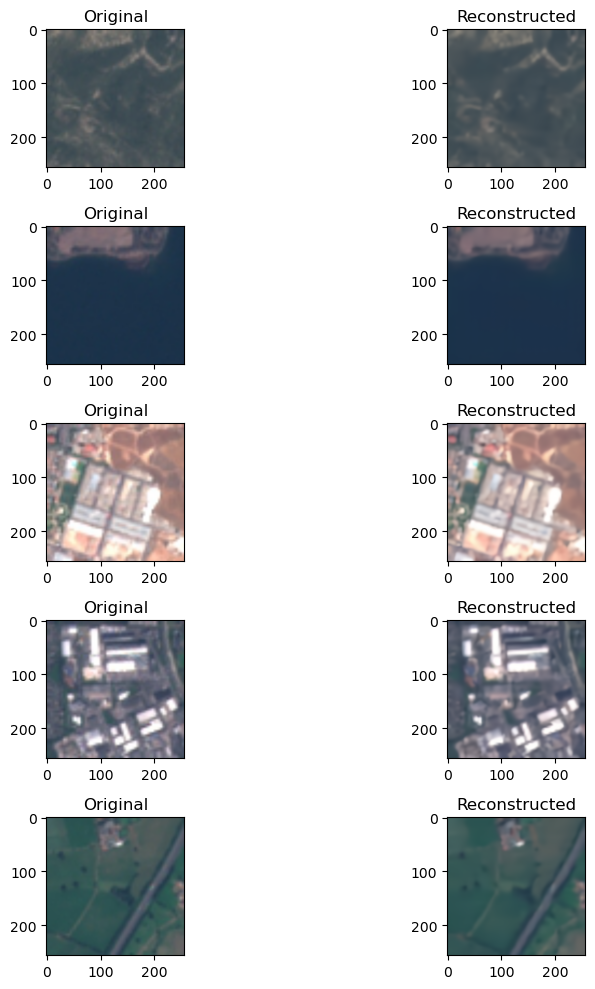

Average PSNR: 41.35683098065077, Average SSIM: 0.9969335632211358
Loss: 3.4560, Accuracy: 0.4489, F1 Score: 0.3939, BPP: 0.0781
6


c:\Users\Alessandro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alessandro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.0294282363962246
Epoch 2, Loss: 1.6236376810073851
Epoch 3, Loss: 1.4849826237007424
Epoch 4, Loss: 1.3481017496850756
Epoch 5, Loss: 1.2583181120731213
Epoch 6, Loss: 1.141590491047612
Epoch 7, Loss: 1.0595042998702437
Epoch 8, Loss: 0.9941316066847907
Epoch 9, Loss: 0.9226134127157706
Epoch 10, Loss: 0.876455633242925
Epoch 11, Loss: 0.844596821113869
Epoch 12, Loss: 0.8063526027290909
Epoch 13, Loss: 0.7732723772525787
Epoch 14, Loss: 0.7502496642095071
Epoch 15, Loss: 0.7235602869810881
Epoch 16, Loss: 0.6998575103724445
Epoch 17, Loss: 0.682646912601259
Epoch 18, Loss: 0.6583248522988072
Epoch 19, Loss: 0.6487054904522719
Epoch 20, Loss: 0.6267955098108009
Epoch 21, Loss: 0.6200922438833448
Epoch 22, Loss: 0.5966631505003682
Epoch 23, Loss: 0.5887645589863812
Epoch 24, Loss: 0.5784025395799566
Epoch 25, Loss: 0.5647836117391233
Epoch 26, Loss: 0.550649211384632
Epoch 27, Loss: 0.5449266115603624
Epoch 28, Loss: 0.5403498821346848
Epoch 29, Loss: 0.5291702390158618

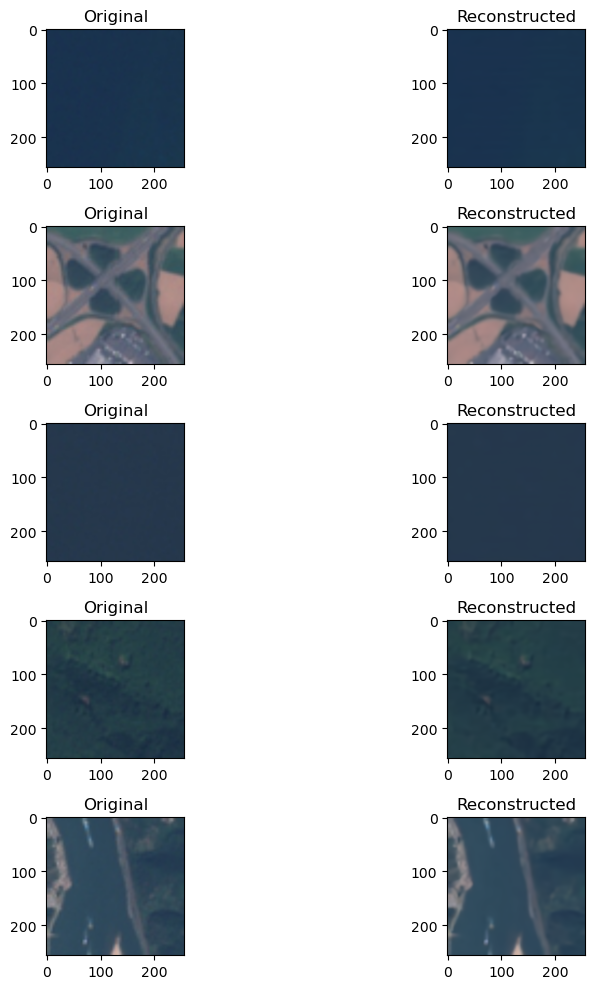

Average PSNR: 44.76313136174129, Average SSIM: 0.9985766848163492
Loss: 5.0703, Accuracy: 0.3891, F1 Score: 0.3537, BPP: 0.1369


In [13]:
device = 'cuda'

for c_model in model_list3:

  if c_model in [bmshj2018_hyperprior, bmshj2018_factorized,mbt2018,mbt2018_mean]:
    start, step, end = 2, 3, 9  # Starting at 2, stepping by 3, up to but not including 9
    Bigger_size = True
  else:
    Bigger_size = False

    start, step, end = 4, 2, 7  # Starting at 2, stepping by 2, up to but not including 7



  print(c_model)

  for i in range(start, end, step):
    print(i)
    model = c_model(quality = i, metric = 'mse', pretrained = True, progress = True).to(device)
    writer = SummaryWriter(f'C:/Users/Alessandro/Desktop/Personal/Contribution 1/Scripts/Pretrained/Tensorboard/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'+f'_{c_model.__name__}'+f'_{i}'+'_ResNet50')

    if Bigger_size is True and i > 4:
      net = ResNetCustomInputClassifier(input_dim = 320 ,num_classes=10).to(device)
    elif Bigger_size is False and i < 4:
      net = ResNetCustomInputClassifier(input_dim = 128,num_classes=10).to(device)
    else:
      net = ResNetCustomInputClassifier(input_dim = 192,num_classes=10).to(device)
    

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.00001)
    
    train(model.to(device), net.to(device), criterion, optimizer, train_dataloader,writer)
    avg_loss, accuracy, f1, bpp_loss = test(model, net, criterion, test_dataloader)
    avg_psnr, avg_ssim = test_model(test_dataloader, model.to(device),device)

    writer.add_scalar(f'{c_model.__name__}_loss', avg_loss, i)
    writer.add_scalar(f'{c_model.__name__}_accuracy', accuracy, i)
    writer.add_scalar(f'{c_model.__name__}_f1', f1, i)
    writer.add_scalar(f'{c_model.__name__}_bpp', bpp_loss, i)
    writer.add_scalar(f'{c_model.__name__}_PSNR', avg_psnr, i)
    writer.add_scalar(f'{c_model.__name__}_SSIM', avg_ssim, i)

    ################################################# NEW CODE

    # Extract latents and labels
    latents, labels = extract_latents(model.to(device), test_dataloader, device=device)

    # Create a t-SNE plot and save to TensorBoard
    fig, ax = plt.subplots(figsize=(10, 6))
    tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
    T = tsne.fit_transform(latents)
    scatter = ax.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Labels')
    plt.title(f't-SNE visualization of {c_model.__name__} Latents with Labels')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
        
    # Log the t-SNE plot to TensorBoard
    writer.add_figure(f'{c_model.__name__}_t-SNE', fig, i)

    ################################################
    writer.flush()
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')

In [ ]:
from torchsummary import summary

# Assuming 'model' is a PyTorch model that has already been defined
print(summary(model, (3,256,256)))  # input_size should be the shape of your model input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 192, 128, 128]           5,376
         LeakyReLU-2        [-1, 192, 128, 128]               0
            Conv2d-3        [-1, 192, 128, 128]         331,968
        LowerBound-4                       [-1]               0
NonNegativeParametrizer-5                       [-1]               0
        LowerBound-6                  [-1, 192]               0
NonNegativeParametrizer-7                  [-1, 192]               0
               GDN-8        [-1, 192, 128, 128]               0
            Conv2d-9        [-1, 192, 128, 128]             768
ResidualBlockWithStride-10        [-1, 192, 128, 128]               0
           Conv2d-11        [-1, 192, 128, 128]         331,968
        LeakyReLU-12        [-1, 192, 128, 128]               0
           Conv2d-13        [-1, 192, 128, 128]         331,968
        LeakyReLU-14   

In [ ]:
import torch

model = mbt2018(quality = 5)

dummy_input = torch.randn(1, 3, 256, 256)  # Change this based on the actual input shape

# Forward pass to get outputs
model.eval()  # Set the model to evaluation mode if not training
with torch.no_grad():  # Ensure no gradients are computed
    output = model(dummy_input)

# Access and print the dimensions of y_likelihood or latent
if 'likelihoods' in output and 'y' in output['likelihoods']:
    y_likelihood = output['likelihoods']['y']
    print('Dimensions of y_likelihood:', y_likelihood.shape)
else:
    print('y_likelihood is not found in the output structure.')




Dimensions of y_likelihood: torch.Size([1, 320, 16, 16])


## JPEG

In [26]:
import time
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import DataLoader
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to a tensor.
    transforms.Resize((256, 256))  # Resize the image to 256x256 for each channel.
])

# Load the whole dataset
whole_dataset = datasets.EuroSAT(
    root="data",
    download=True,
    transform=transform
)

# Determine the lengths of the splits
train_len = int(len(whole_dataset) * 0.8)  # 80% for training
test_len = len(whole_dataset) - train_len  # 20% for testing

# Create the splits
training_data, test_data = torch.utils.data.random_split(whole_dataset, [train_len, test_len])
# Create the data loaders
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)



# Define the Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# Define the Transformer Classifier class
class TransformerClassifier(nn.Module):
    def __init__(self, in_size, num_classes=10, num_heads=8, num_layers=6, hidden_dim=512):
        super(TransformerClassifier, self).__init__()
        self.input_projection = nn.Linear(in_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1).float()  # Flatten spatial dimensions and convert to float32
        x = self.input_projection(x)
        x = x.unsqueeze(1)  # Add a sequence dimension
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x
    

import time
import numpy as np
import torch
from PIL import Image
from io import BytesIO
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to encode image to JPEG and decode back
def jpeg_encode_decode(image, quality=100):
    # Convert tensor to numpy array
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
    image_pil = Image.fromarray((image_np * 255).astype('uint8'))
    
    # Encode to JPEG
    buffer = BytesIO()
    start_encode_time = time.time()
    image_pil.save(buffer, format="JPEG", quality=quality)
    encode_time = time.time() - start_encode_time
    
    # Calculate BPP
    image_size = buffer.tell() * 8  # Size in bits
    num_pixels = image_np.shape[0] * image_np.shape[1]
    bpp = image_size / num_pixels
    
    # Decode from JPEG
    buffer.seek(0)
    start_decode_time = time.time()
    image_pil = Image.open(buffer)
    image_decoded = np.array(image_pil) / 255.0
    decode_time = time.time() - start_decode_time
    
    # Convert back to tensor
    image_decoded_tensor = torch.tensor(image_decoded).permute(2, 0, 1).float()  # Change from (H, W, C) to (C, H, W) and convert to float32
    
    return image_decoded_tensor, encode_time, decode_time, bpp

# Function to evaluate JPEG encoding on the dataset
def evaluate_jpeg(dataloader, device):
    encode_times = []
    decode_times = []
    psnr_values = []
    decoded_images = []
    labels_list = []
    bpp_values = []

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        for i in range(images.size(0)):
            image = images[i]
            label = labels[i].item()
            decoded_image, encode_time, decode_time, bpp = jpeg_encode_decode(image)
            encode_times.append(encode_time)
            decode_times.append(decode_time)
            bpp_values.append(bpp)
            psnr_value = psnr(image.cpu().numpy(), decoded_image.cpu().numpy())
            psnr_values.append(psnr_value)
            decoded_images.append(decoded_image)
            labels_list.append(label)
    
    avg_encode_time = np.mean(encode_times)
    avg_decode_time = np.mean(decode_times)
    avg_psnr = np.mean(psnr_values)
    avg_bpp = np.mean(bpp_values)
    print(f"Average JPEG Encoding Time: {avg_encode_time:.6f} seconds")
    print(f"Average JPEG Decoding Time: {avg_decode_time:.6f} seconds")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average Bits per Pixel (BPP): {avg_bpp:.4f}")
    
    return decoded_images, labels_list



# Evaluate JPEG encoding
decoded_images, labels = evaluate_jpeg(test_dataloader, device)

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate_model(model, dataloader, device):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
    return all_targets, all_predictions

# Instantiate the classifier
in_size = 256 * 256 * 3  # Example input size for the TransformerClassifier
num_classes = 10
classifier = TransformerClassifier(in_size=in_size, num_classes=num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(50):
    epoch_loss = train_model(classifier, train_dataloader, criterion, optimizer, device)
    print(f"Epoch {epoch + 1} completed with loss: {epoch_loss:.4f}")

# Evaluation
targets, predictions = evaluate_model(classifier, test_dataloader, device)
f1 = f1_score(targets, predictions, average='weighted')
print(f"Classification F1 Score: {f1:.4f}")


Average JPEG Encoding Time: 0.001416 seconds
Average JPEG Decoding Time: 0.001263 seconds
Average PSNR: 49.55 dB
Average Bits per Pixel (BPP): 2.8484
torch.Size([3, 256, 256])
Epoch 1 completed with loss: 2.4807
Epoch 2 completed with loss: 2.4808
Epoch 3 completed with loss: 2.4830
Epoch 4 completed with loss: 2.4812


KeyboardInterrupt: 

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import time
import numpy as np
from PIL import Image
from io import BytesIO
from skimage.metrics import peak_signal_noise_ratio as psnr
import math
from sklearn.metrics import f1_score

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to a tensor.
    transforms.Resize((224, 224))  # Resize the image to 256x256 for each channel.
])

# Load the whole dataset
whole_dataset = datasets.EuroSAT(
    root="data",
    download=True,
    transform=transform
)

# Determine the lengths of the splits
train_len = int(len(whole_dataset) * 0.8)  # 80% for training
test_len = len(whole_dataset) - train_len  # 20% for testing

# Create the splits
training_data, test_data = random_split(whole_dataset, [train_len, test_len])

# Create the data loaders
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

# Function to encode image to JPEG and decode back
def jpeg_encode_decode(image, quality=100):
    # Convert tensor to numpy array
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
    image_pil = Image.fromarray((image_np * 255).astype('uint8'))
    
    # Encode to JPEG
    buffer = BytesIO()
    start_encode_time = time.time()
    image_pil.save(buffer, format="JPEG", quality=quality)
    encode_time = time.time() - start_encode_time
    
    # Calculate BPP
    image_size = buffer.tell() * 8  # Size in bits
    num_pixels = image_np.shape[0] * image_np.shape[1]
    bpp = image_size / num_pixels
    
    # Decode from JPEG
    buffer.seek(0)
    start_decode_time = time.time()
    image_pil = Image.open(buffer)
    image_decoded = np.array(image_pil) / 255.0
    decode_time = time.time() - start_decode_time
    
    # Convert back to tensor
    image_decoded_tensor = torch.tensor(image_decoded).permute(2, 0, 1).float()  # Change from (H, W, C) to (C, H, W) and convert to float32
    
    return image_decoded_tensor, encode_time, decode_time, bpp

# Function to evaluate JPEG encoding on the dataset
def evaluate_jpeg(dataloader, device, quality):
    encode_times = []
    decode_times = []
    psnr_values = []
    decoded_images = []
    labels_list = []
    bpp_values = []

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        for i in range(images.size(0)):
            image = images[i]
            label = labels[i].item()
            decoded_image, encode_time, decode_time, bpp = jpeg_encode_decode(image, quality=quality)
            encode_times.append(encode_time)
            decode_times.append(decode_time)
            bpp_values.append(bpp)
            psnr_value = psnr(image.cpu().numpy(), decoded_image.cpu().numpy())
            psnr_values.append(psnr_value)
            decoded_images.append(decoded_image)
            labels_list.append(label)
    
    avg_encode_time = np.mean(encode_times)
    avg_decode_time = np.mean(decode_times)
    avg_psnr = np.mean(psnr_values)
    avg_bpp = np.mean(bpp_values)
    print(f"Average JPEG Encoding Time: {avg_encode_time:.6f} seconds")
    print(f"Average JPEG Decoding Time: {avg_decode_time:.6f} seconds")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average Bits per Pixel (BPP): {avg_bpp:.4f}")
    
    return decoded_images, labels_list

# Define the MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, in_size, num_classes=10):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(in_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pretrained ResNet
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)  # Modify for 10 classes
resnet = resnet.to(device)

# Pretrained Vision Transformer (ViT)
vit = models.vit_b_16(pretrained=True)
vit.heads.head = nn.Linear(vit.heads.head.in_features, 10)  # Modify for 10 classes
vit = vit.to(device)

# MLP
in_size = 3 * 224 * 224  # Input size for the MLP
mlp = MLPClassifier(in_size=in_size, num_classes=10).to(device)

# Function to train the model
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
    return all_targets, all_predictions

# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Train and evaluate the models on JPEG decoded images at different quality levels
jpeg_qualities = [10, 40,70, 100]

for quality in jpeg_qualities:
    print(f"Evaluating at JPEG quality: {quality}")
    
    # Evaluate JPEG encoding
    decoded_images, labels = evaluate_jpeg(test_dataloader, device, quality=quality)

    # Convert decoded images to a tensor dataset
    decoded_dataset = torch.utils.data.TensorDataset(torch.stack(decoded_images), torch.tensor(labels))
    decoded_dataloader = DataLoader(decoded_dataset, batch_size=32, shuffle=False)

    for model, model_name in zip([mlp, resnet, vit], ["MLP", "ResNet", "ViT"]):
        # Initialize optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        for epoch in range(5):  # Use fewer epochs for quick evaluation
            epoch_loss = train_model(model, train_dataloader, criterion, optimizer, device)
            print(f"{model_name} - Epoch {epoch + 1} completed with loss: {epoch_loss:.4f}")

        # Evaluation
        targets, predictions = evaluate_model(model, decoded_dataloader, device)
        f1 = f1_score(targets, predictions, average='weighted')
        print(f"{model_name} - JPEG Quality {quality} - Classification F1 Score: {f1:.4f}")

print("Evaluation completed.")


c:\Users\Alessandro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alessandro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Alessandro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get 

Evaluating at JPEG quality: 10
Average JPEG Encoding Time: 0.000632 seconds
Average JPEG Decoding Time: 0.000796 seconds
Average PSNR: 32.14 dB
Average Bits per Pixel (BPP): 0.2788
MLP - Epoch 1 completed with loss: 2.2674
MLP - Epoch 2 completed with loss: 1.6349
MLP - Epoch 3 completed with loss: 1.5758
MLP - Epoch 4 completed with loss: 1.5335
MLP - Epoch 5 completed with loss: 1.5144
MLP - JPEG Quality 10 - Classification F1 Score: 0.3967
ResNet - Epoch 1 completed with loss: 0.4122
ResNet - Epoch 2 completed with loss: 0.2388
ResNet - Epoch 3 completed with loss: 0.1769
ResNet - Epoch 4 completed with loss: 0.1552
ResNet - Epoch 5 completed with loss: 0.1303
ResNet - JPEG Quality 10 - Classification F1 Score: 0.4398
ViT - Epoch 1 completed with loss: 1.4702
ViT - Epoch 2 completed with loss: 0.9737
ViT - Epoch 3 completed with loss: 0.8373
ViT - Epoch 4 completed with loss: 0.7090
ViT - Epoch 5 completed with loss: 0.5783
ViT - JPEG Quality 10 - Classification F1 Score: 0.4852
Eva

In [ ]:
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

def test_model(test_dataloader, net, device):
    net.eval()
    avg_psnr = 0.0
    avg_ssim = 0.0
    total_batches = len(test_dataloader)
    total_encode_time = 0.0
    total_decode_time = 0.0
    total_bpp = 0.0


    with torch.no_grad():
        for i, (batch, _) in enumerate(test_dataloader):
            batch = batch.to(device)
            

            
            # Measure encode time
            start_time = time.time()
            outputs = net(batch)
            encode_time = time.time() - start_time
            
            # Measure decode time
            start_time = time.time()
            x_hat = outputs["x_hat"]
            decode_time = time.time() - start_time
            
            y_likelihoods = outputs["likelihoods"]["y"]

            mse_loss = F.mse_loss(batch, x_hat)
            max_i = 1.0  # Normalize input to [0, 1]
            batch_psnr = 10 * torch.log10(max_i ** 2 / mse_loss)
            avg_psnr += batch_psnr.item()

            # Ensure y_likelihoods are strictly positive
            y_likelihoods = torch.clamp(y_likelihoods, min=1e-9)    



            # Calculate the bitrate of the quantized latent
            N, _, H, W = y_likelihoods.size()
            num_pixels = N * H * W 

            total_bpp = torch.log(y_likelihoods).sum() / (-math.log(2) * num_pixels)

            total_encode_time += encode_time
            total_decode_time += decode_time


        avg_psnr /= total_batches
        avg_ssim /= total_batches
        avg_encode_time = total_encode_time / total_batches
        avg_decode_time = total_decode_time / total_batches
        avg_bpp = total_bpp / total_batches

 
    print(f"Average PSNR: {avg_psnr}")
    print(f"Average encode time: {avg_encode_time:.4f} seconds")
    print(f"Average decode time: {avg_decode_time:.4f} seconds")
    print(f"Average bits per pixel (bpp): {avg_bpp:.4f}")

    return avg_psnr, avg_encode_time, avg_decode_time, avg_bpp


In [ ]:
model_list = [bmshj2018_hyperprior,bmshj2018_factorized,mbt2018_mean,mbt2018,cheng2020_anchor,cheng2020_attn]

# Main function to evaluate models
def evaluate_models(model_list, dataloader, device):
    for c_model in model_list:
        if c_model in [bmshj2018_hyperprior, bmshj2018_factorized, mbt2018, mbt2018_mean]:
            start, step, end = 2, 3, 9  # Starting at 2, stepping by 3, up to but not including 9
        else:
            start, step, end = 2, 2, 7  # Starting at 2, stepping by 2, up to but not including 7

        print(c_model)

        for i in range(start, end, step):
            print(i)
            model = c_model(quality=i, metric='mse', pretrained=True, progress=True).to(device)

            # Evaluate model
            avg_psnr, avg_encode_time, avg_decode_time, avg_bpp = test_model(dataloader, model, device)
            
            print(f'Encode Time: {avg_encode_time:.4f} seconds, Decode Time: {avg_decode_time:.4f} seconds, PSNR: {avg_psnr:.2f} dB,  BPP: {avg_bpp:.4f}')
            
evaluate_models(model_list, test_dataloader, device)

<function bmshj2018_hyperprior at 0x000002C347CFFEC0>
2
Average PSNR: 37.04296452900362
Average encode time: 0.0214 seconds
Average decode time: 0.0000 seconds
Average bits per pixel (bpp): 0.1012
Encode Time: 0.0214 seconds, Decode Time: 0.0000 seconds, PSNR: 37.04 dB,  BPP: 0.1012
5
Average PSNR: 42.74601318991396
Average encode time: 0.0202 seconds
Average decode time: 0.0000 seconds
Average bits per pixel (bpp): 0.1935
Encode Time: 0.0202 seconds, Decode Time: 0.0000 seconds, PSNR: 42.75 dB,  BPP: 0.1935
8
Average PSNR: 49.13879647339589
Average encode time: 0.0294 seconds
Average decode time: 0.0000 seconds
Average bits per pixel (bpp): 0.4911
Encode Time: 0.0294 seconds, Decode Time: 0.0000 seconds, PSNR: 49.14 dB,  BPP: 0.4911
<function bmshj2018_factorized at 0x000002C347CFFCE0>
2
Average PSNR: 37.2307647163346
Average encode time: 0.0193 seconds
Average decode time: 0.0000 seconds
Average bits per pixel (bpp): 0.1599
Encode Time: 0.0193 seconds, Decode Time: 0.0000 seconds, PS

In [ ]:
from torchsummary import summary

# Create a model instance
in_size = 320 * 16 * 16
num_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetCustomInputClassifier(input_dim= 320, num_classes=num_classes).to(device)

# Count the number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())

total_params

c:\Users\Alessandro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alessandro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


24522634

In [ ]:
summary(ResNetCustomInputClassifier(input_dim= 320,num_classes=num_classes).to(device), (320, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]       1,003,520
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5             [-1, 64, 4, 4]           4,096
       BatchNorm2d-6             [-1, 64, 4, 4]             128
              ReLU-7             [-1, 64, 4, 4]               0
            Conv2d-8             [-1, 64, 4, 4]          36,864
       BatchNorm2d-9             [-1, 64, 4, 4]             128
             ReLU-10             [-1, 64, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]          16,384
      BatchNorm2d-12            [-1, 256, 4, 4]             512
           Conv2d-13            [-1, 256, 4, 4]          16,384
      BatchNorm2d-14            [-1, 25

# Notes from underground

### Role of Positional Encoding
Maintaining Spatial Structure:

Just as positional encoding helps maintain the order of tokens in sequences for NLP tasks, it helps maintain the spatial structure of the latent representations in image data.
The positional encodings provide a sense of location for each element in the latent space, which can be crucial for capturing spatial hierarchies and patterns that are important for classification.
Transformer's Attention Mechanism:

The self-attention mechanism in Transformers computes relationships between different positions in the input. Without positional encoding, the Transformer would not differentiate between different positions in the latent space.
By adding positional encodings, the Transformer can attend to different parts of the latent space based on their positions, thus effectively capturing spatial dependencies.
Generalizing Across Latent Spaces:

Positional encodings enable the Transformer to generalize across different latent spaces, making it possible to learn from the positional information within the compressed representations.
This is particularly useful when dealing with varying sizes and shapes of latent spaces derived from different images or even different compression methods.

### Applying Positional Encoding to Latent Spaces
In the implementation of the TransformerClassifier, positional encoding can be applied to the flattened latent representations as follows:

Flattening Latent Spaces:

The latent space representation of an image, which might originally be in a 3D shape (e.g., [batch_size, channels, height, width]), is flattened to a 2D shape (e.g., [batch_size, sequence_length, embedding_dim]).
Adding Positional Encoding:

Positional encodings are added to these flattened representations to encode spatial information.
Transformer Encoder:

The positional encoding augmented latent spaces are then passed through the Transformer encoder, which can now leverage both the feature information and the positional information to perform classification.